In [25]:
import pandas as pd
import tensorflow as tf
import numpy as np
import math

In [26]:
train = pd.read_csv("train.tsv", sep='\t')

In [27]:
train.head()

,tags,description
0,licence-needed supervising-job 5-plus-years-ex...,THE COMPANY Employer is a midstream service...
1,2-4-years-experience-needed salary full-time-job,ICR Staffing is now accepting resumes for Indu...
2,part-time-job,This is a great position for the right person....
3,licence-needed,A large multi-specialty health center is expan...
4,5-plus-years-experience-needed full-time-job b...,JOB PURPOSE: The Account Director is respon...


In [28]:
test = pd.read_csv("test.tsv", sep='\t')

In [29]:
test.head()

,description
0,Integrity Home Care has an opening on our Lead...
1,We're looking for a precision grinder with at ...
2,In Home Sales Designer Georgia Shutters– Augus...
3,Advanced Radiotherapy Consulting is seeking an...
4,Position Requirements: · Professional ...


In [30]:
myTrainTags = train['tags'].tolist()
myTrainDesc = train['description'].tolist()
myTestDesc = test['description'].tolist()

In [31]:
allTags = ['part-time-job',
          'full-time-job',
          'hourly-wage',
          'salary',
          'associate-needed',
          'bs-degree-needed',
          'ms-or-phd-needed',
          'licence-needed',
          '1-year-experience-needed',
          '2-4-years-experience-needed',
          '5-plus-years-experience-needed',
          'supervising-job']

In [32]:
count = 0
numWords = []
for desc in myTrainDesc:
    numWords.append(len(desc.split()))
print ("Average number of words per file", (sum(numWords)/len(numWords)))
avgNumWords = sum(numWords)/len(numWords)
numTrainFiles = len(numWords)
numTestFiles = len(myTestDesc)

Average number of words per file 259.44685714285714


In [33]:
trainLabels = np.zeros((numTrainFiles, len(allTags)), dtype='int32')
for index,tag in enumerate(myTrainTags):
    if (isinstance(tag, float) and math.isnan(tag)):
        continue
    split = tag.split()
    for word in split:
        trainLabels[index][allTags.index(word)] = 1

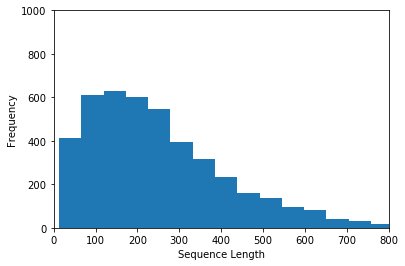

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 800, 0, 1000])
plt.show()

In [35]:
wordsList = np.load('wordsList.npy')
wordsList = wordsList.tolist()
wordsList = [word.decode('UTF-8') for word in wordsList] 
wordVectors = np.load('wordVectors.npy')
maxSeqLength = 300

In [36]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [37]:
ids = np.zeros((numTrainFiles, maxSeqLength), dtype='int32')
#fileCounter = 0
#for fileCounter, desc in enumerate(myTrainDesc):
#    cleanedLine = cleanSentences(desc)
#    split = cleanedLine.split()
#    indexCounter = 0
#    for word in split:
#        try:
#            ids[fileCounter][indexCounter] = wordsList.index(word)
#        except ValueError:
#            ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#        indexCounter = indexCounter + 1
#        if indexCounter >= maxSeqLength:
#            break

In [38]:
testIds = np.zeros((numTestFiles, maxSeqLength), dtype='int32')
#fileCounter = 0
#for fileCounter, desc in enumerate(myTestDesc):
#    cleanedLine = cleanSentences(desc)
#    split = cleanedLine.split()
#    indexCounter = 0
#    for word in split:
#        try:
#            testIds[fileCounter][indexCounter] = wordsList.index(word)
#        except ValueError:
#            testIds[fileCounter][indexCounter] = 399999 #Vector for unkown words
#        indexCounter = indexCounter + 1
#        if indexCounter >= maxSeqLength:
#            break
#np.save('testIdsMatrix', testIds)

In [39]:
ids = np.load('idsMatrix.npy')
testIds = np.load('testIdsMatrix.npy')

In [45]:
batchSize = 24
lstmUnits = 128
numClasses = len(allTags)
iterations = 100000
numDimensions = 50
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [46]:
from random import randint

def getTrainBatch():
    tLabels = []
    arr = np.zeros([batchSize, maxSeqLength])
    num = randint(1 + batchSize,3500)
    arr = ids[num-batchSize:num]
    tLabels = trainLabels[num-batchSize:num]
    return arr, tLabels

def getValidationBatch():
    tLabels = []
    arr = np.zeros([batchSize, maxSeqLength])
    num = randint(3500,len(ids))
    arr = ids[num-batchSize:num]
    tLabels = trainLabels[num-batchSize:num]
    return arr, tLabels

def getTestBatch():
    arr = np.zeros([batchSize, maxSeqLength])
    num = randint(1 + batchSize,len(testIds))
    arr = testIds[num-batchSize:num]
    return arr

In [47]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [48]:
import datetime

tf.summary.scalar('Loss', loss)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

In [59]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [61]:
testIterations = 1
for i in range(testIterations):
    nextBatch = getTestBatch();
    t = (sess.run(prediction, {input_data: nextBatch, labels: nextBatchLabels}))
tr = np.asmatrix(t)
tr[0]


matrix([[ 1150.05566406,  1152.83032227,  1152.65087891,  1152.55480957,
          1150.70532227,  1153.68103027,  1080.94006348,  1152.92956543,
          1149.82592773,  1153.12658691,  1152.78710938,  1153.11193848]], dtype=float32)